In [1]:
## XGBoost 
# State 1 hot 
# Rurality Data
# SVI poverty index
# Minority?


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import xgboost as xgb 
import shap
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
main_path = Path.cwd().parent.parent
data_path = main_path / 'Data'

#svi = pd.read_csv( data_path / 'Master Project Data' /'SVI Tract Data.csv',  )


In [4]:
# import stored methods 
path = Path.cwd().parent.parent

LoadAndCleanARCP = main_path /'src' /'data'/ 'LoadAndCleanARCP.py'
LoadAndCleanACS = main_path /'src' /'data'/ 'LoadAndCleanACS.py'
# Run methods to obtain clean datasets 

%run $LoadAndCleanARCP
%run $LoadAndCleanACS

ValueError: Wrong number of items passed 3, placement implies 1

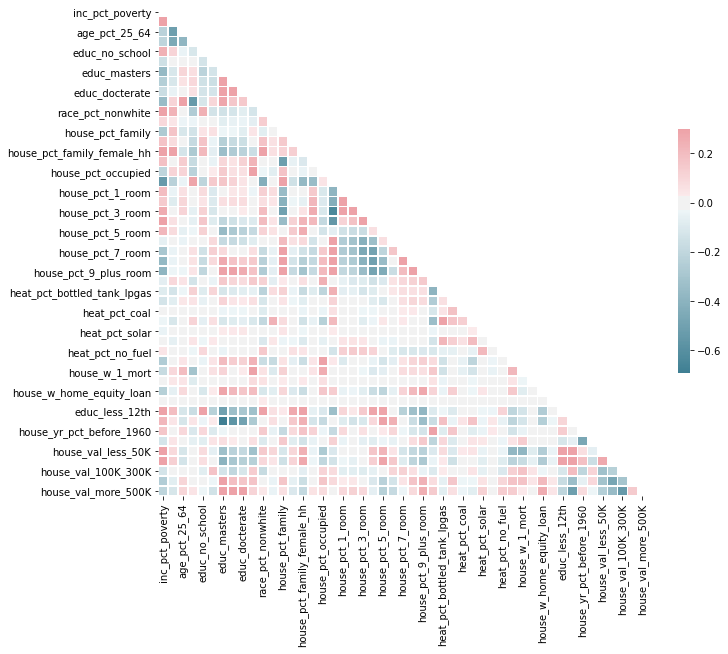

In [28]:
#Find correlated features in ACS dataset and identify the highly correlated relationships

# Create ACS correlation matrix
corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
print(corr_high.sort_values(by=['Corr Value'], ascending=False))




#From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_rent_occupied',
                           'race_pct_white', 'race_pct_nonwhitenh','race_pct_hisp', 'house_pct_incomplete_plumb',
                           'house_pct_incomplete_kitchen', 'race_pct_whitenh','house_no_mort',
                           'race_pct_black','house_pct_live_alone','house_pct_family_married','educ_bachelors',
                           'heat_pct_electricity','house_pct_complete_kitchen','house_yr_pct_1960_2000'], axis=1) 





print (ACS.head())


In [ ]:
ACS['house_pct']

In [57]:
# Based on feature importance experiments, select features with consistence importance across annual predictions
ACS_reduced = ACS[['heat_pct_coal','heat_pct_solar','house_yr_pct_before_1960','educ_less_12th','heat_pct_wood',
                  'inc_pct_poverty','age_pct_over65','race_pct_nonwhite','house_val_100K_300K','educ_no_school',
                  'house_pct_ownd_occupied','heat_pct_utility_gas','house_w_home_equity_loan','house_val_less_50K',
                  'educ_high_school','house_pct_family','heat_pct_other','house_pct_family_female_hh']]



In [58]:
# smoke detector statistical model munging
sm = pd.read_csv(  data_path /'Model Outputs'/'SmokeAlarmModelOutput.csv')
sm['geoid'] = sm['geoid'].str[2:]
sm['tract'] = sm['geoid'].str[:-1]
sm.set_index('geoid', inplace =  True)
sm_all = sm.copy()
sm_all = sm[ sm['geography'].isin(['county','state']) ]

sm = sm[ sm['geography'].isin(['tract','block']) ]


In [59]:
rd = pd.read_csv( data_path / 'Master Project Data' /'Tract Rurality Data.csv', dtype = {'FIPS':'object'},encoding = 'latin-1' )

In [68]:
def create_rurality_data(sm,subset_county = False): 
    #Rurality Data Munging 
    rd = pd.read_csv( data_path / 'Master Project Data' /'Tract Rurality Data.csv', dtype = {'FIPS':'object'},encoding = 'latin-1' )
    rd['Population Density (per square mile), 2010'] =  rd['Population Density (per square mile), 2010'].str.replace(',','').astype('float')
    rd = rd.iloc[:,[0,2,4,6,8]]
    block_tract = sm['tract'].to_frame()
    block_tract = block_tract.reset_index()
    rd = block_tract.merge(rd, how = 'left', left_on = 'tract' , right_on ='FIPS')
    rd.set_index('geoid',inplace= True)
    rd = rd.iloc[:,2:]
    rd['Select State'] = rd['Select State'].astype('category')

    # add state level model estimates 
    sms = pd.rd = pd.read_csv( data_path /'Model Outputs'/'Smoke_Alarm_Single_Level'/ 'SmokeAlarmModelState.csv')
    sms['geoid'] = sms['geoid'].str[2:]
    sms =  sms.loc[:,['geoid','detectors_found_prc']]
    sms = sms.rename(columns= {'geoid':'state_geoid'}  )

    rd['state_geoid'] = rd.index.str[:2]
    rd = rd.reset_index()
    rd = rd.merge(sms,how = 'left', on = 'state_geoid' )
    rd.drop('state_geoid',axis = 1,inplace = True)
    rd = rd.rename(columns = {'detectors_found_prc':'state_detectors_found_prc'}) 
    rd = rd.set_index('geoid')


    # add county level estimates
    smc = pd.read_csv( data_path /'Model Outputs'/'Smoke_Alarm_Single_Level'/ 'SmokeAlarmModelCounty.csv')
    smc['geoid'] = smc['geoid'].str[2:]
    if subset_county:
        smc.iloc[0::2,:] = np.nan
    smc =  smc.loc[:,['geoid','detectors_found_prc']]
    smc = smc.rename(columns= {'geoid':'county_geoid'}  )

    rd['county_geoid'] = rd.index.str[:5]
    rd = rd.reset_index()
    rd = rd.merge(smc,how = 'left', on = 'county_geoid' )
    rd.drop('county_geoid',axis = 1,inplace = True)
    rd = rd.rename(columns = {'detectors_found_prc':'county_detectors_found_prc'}) 
    rd = rd.set_index('geoid')
  #  rd['RUCA_rurality_index'] = rd['Primary RUCA Code 2010']
  #  rd[rd['RUCA_rurality_index'] > 10 ] = np.NaN
    rd = rd.iloc[:,3:]

    return rd 

# alternative 1 hot based encoding
#rd = rd.merge( pd.get_dummies(rd['Select State']), how = 'left', on= 'geoid')


In [69]:
rd = create_rurality_data(sm,True)
rd_all = create_rurality_data(sm_all)

In [70]:
def train_model(X = rd, y= sm, ACS = pd.DataFrame(),predict ='Presence', modeltype='XGBoost'):
    from scipy.stats import zscore, pearsonr
    from sklearn.metrics import auc, accuracy_score, confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score, r2_score

    assert(predict in ['Presence', 'Working']) 
   
    
    # Define model types & parameters 
    
    if modeltype =='LinearRegression':
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
    if modeltype =='ElasticNet':    
        from sklearn.linear_model import ElasticNet
        model = ElasticNet()
    if modeltype =='Ridge':    
        from sklearn.linear_model import Ridge
        model = Ridge()
    if modeltype =='Lasso':    
        from sklearn.linear_model import Lasso
        model = Lasso()       
        
       
        
    elif modeltype =='XGBoost':
        model = xgb.XGBRegressor(objective = 'reg:squarederror',random_state = 0)
            
  
    if  predict == 'Presence':
        y = y['detectors_found_prc']
    elif predict =='Working':
        y = y['detectors_working_prc']


    # merge in ACS Data into X unless NFIRS-Only model
    if not ACS.empty:
        X = X.merge(ACS, how ='left',left_index = True, right_index = True)
        X = X.dropna()
        y = y.filter(X.index)
    
    # Create 80/20 training/testing set split
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )

    # Perform cross-validation 

    #scaler = preprocessing.StandardScaler().fit(X)
    #scaler.transform(X)
    #print ('Cross Val Score:')
    #print(cross_val_score(model, X, y))

    # Standardize features by removing the mean and scaling to unit variance
    
    #scaler = preprocessing.StandardScaler().fit(X_train)
    #X_columns = X_train.columns
    #X_train =  pd.DataFrame(scaler.transform(X_train), columns = X_columns )
    #X_test  =  pd.DataFrame(scaler.transform(X_test) , columns = X_columns )

    # Fit model to training set

    model = model.fit(X_train,y_train)

    # Calculate training set performance
    train_predictions = model.predict(X_train)
    print('-----Training_Performance------')
    print(mean_squared_error(y_train, train_predictions))
    print ('Test RMSE: {}'.format(mean_squared_error(y_train, train_predictions, squared = False)) )
    print ('Test MAE: {}'.format(mean_absolute_error(y_train, train_predictions)) )
    sns.scatterplot(y_train,train_predictions) 
    plt.show()
    
    # Calculate test set performance
    test_predictions = model.predict(X_test)
    print ('-----Test Performance ----- ')
    print ('Test RMSE: {}'.format(mean_squared_error(y_test, test_predictions, squared = False)) )
    print ('Test MAE: {}'.format(mean_absolute_error(y_test, test_predictions)) )
    sns.scatterplot(y_test,test_predictions) 
    plt.show()
    print ('Test Correlation: {}'.format(pearsonr(y_test, test_predictions)) )
    print ('Test R-squared: {}'.format(r2_score(y_test, test_predictions)) )


    #Calculate feature importance for each model
    if modeltype == 'XGBoost':
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("\n Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]])) 


    return  model,X_test,y_test



-----Training_Performance------
15.744488926650881
Test RMSE: 3.967932575870069
Test MAE: 2.917442583719504


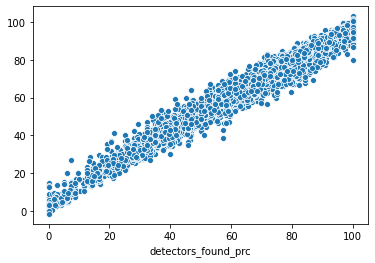

-----Test Performance ----- 
Test RMSE: 13.415129350377907
Test MAE: 9.8823621436132


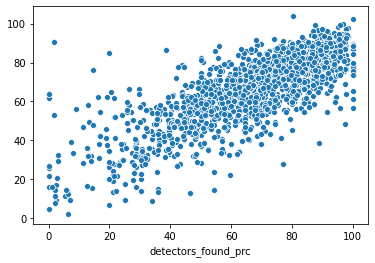

Test Correlation: (0.7826644972913016, 7.7e-321)
Test R-squared: 0.6103189767880837

 Feature ranking:
1. county_detectors_found_prc (0.388456)
2. educ_less_12th (0.025348)
3. house_val_more_500K (0.018850)
4. heat_pct_solar (0.018338)
5. house_yr_pct_before_1960 (0.018057)
6. race_pct_nonwhite (0.017665)
7. house_pct_3_room (0.016671)
8. house_val_100K_300K (0.016667)
9. educ_no_school (0.015491)
10. heat_pct_utility_gas (0.013998)
11. house_val_300K_500K (0.013968)
12. house_pct_complete_plumb (0.013915)
13. Population Density (per square mile), 2010 (0.013777)
14. house_val_less_50K (0.013616)
15. age_pct_over65 (0.013600)
16. educ_professional (0.013279)
17. educ_masters (0.013117)
18. house_yr_pct_after_2000 (0.012880)
19. house_pct_family (0.012671)
20. house_pct_1_room (0.012661)
21. house_pct_2_room (0.012524)
22. educ_high_school (0.012507)
23. race_pct_amind (0.012404)
24. house_pct_occupied (0.012264)
25. heat_pct_wood (0.011995)
26. house_pct_7_room (0.011609)
27. house_val

In [71]:
mdl,X_test,y_test = train_model(X = rd, y = sm , ACS = ACS  ,modeltype= 'XGBoost')

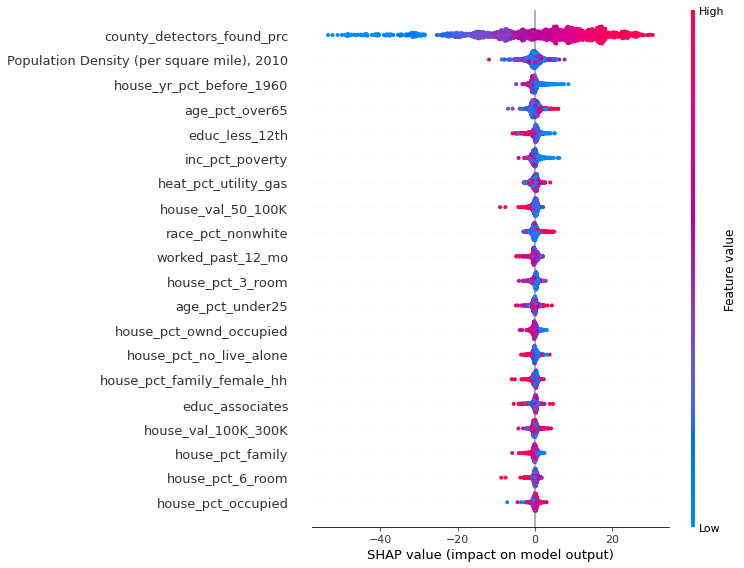

In [72]:
f, ax = plt.subplots(1, 1, figsize = (15, 10))
shap_values =shap.TreeExplainer(mdl).shap_values(X_test)
shap.summary_plot(shap_values,X_test)
plt.show()

-----Training_Performance------
28.674018367507237
Test RMSE: 5.354812636078618
Test MAE: 3.913043244575857


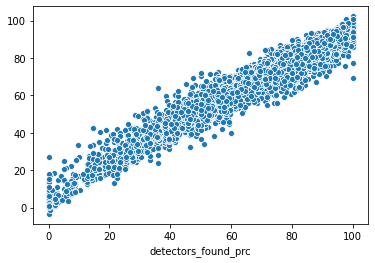

-----Test Performance ----- 
Test RMSE: 12.834602317962451
Test MAE: 9.34656390234453


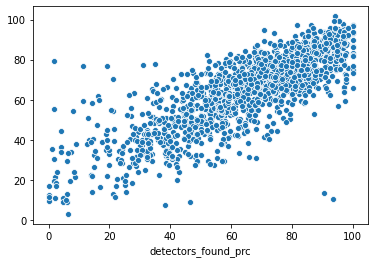

Test Correlation: (0.8021711125142839, 0.0)
Test R-squared: 0.6416785734589081

 Feature ranking:
1. county_detectors_found_prc (0.568649)
2. educ_high_school (0.026280)
3. age_pct_over65 (0.025530)
4. house_val_less_50K (0.025011)
5. house_w_home_equity_loan (0.024939)
6. race_pct_nonwhite (0.024636)
7. educ_no_school (0.023245)
8. heat_pct_utility_gas (0.022639)
9. house_pct_ownd_occupied (0.022236)
10. Population Density (per square mile), 2010 (0.022152)
11. educ_less_12th (0.021860)
12. house_pct_family_female_hh (0.021759)
13. house_yr_pct_before_1960 (0.021243)
14. heat_pct_wood (0.021187)
15. house_pct_family (0.020497)
16. heat_pct_solar (0.019840)
17. house_val_100K_300K (0.019444)
18. inc_pct_poverty (0.019080)
19. heat_pct_coal (0.018197)
20. state_detectors_found_prc (0.016209)
21. heat_pct_other (0.015367)


In [73]:
mdl2,X_test,y_test =train_model(X = rd, y = sm , ACS = ACS_reduced  ,modeltype= 'XGBoost')

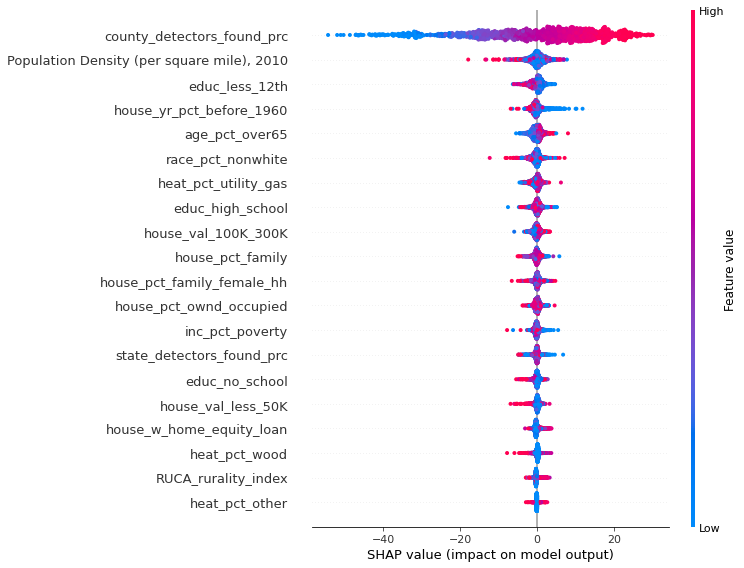

In [66]:
f, ax = plt.subplots(1, 1, figsize = (15, 10))
shap_values =shap.TreeExplainer(mdl2).shap_values(X_test)
shap.summary_plot(shap_values,X_test)
plt.show()

-----Training_Performance------
116.76205590807204
Test RMSE: 10.805649258978937
Test MAE: 7.920879611053617


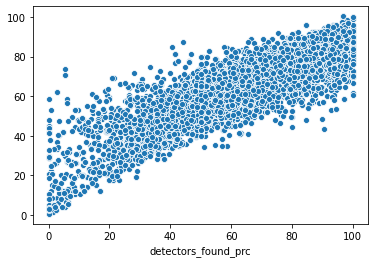

-----Test Performance ----- 
Test RMSE: 12.434796616042332
Test MAE: 8.986409250438978


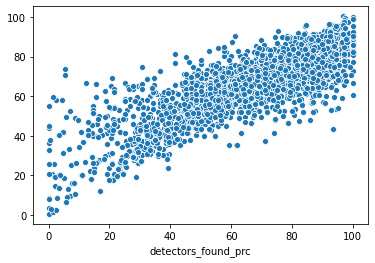

Test Correlation: (0.8279905644954617, 0.0)
Test R-squared: 0.6779421646881038

 Feature ranking:
1. county_detectors_found_prc (0.586218)
2. state_detectors_found_prc (0.309474)
3. Population Density (per square mile), 2010 (0.104307)


In [76]:
mdl3,X_test,y_test=train_model(X = rd, y = sm ,modeltype= 'XGBoost')

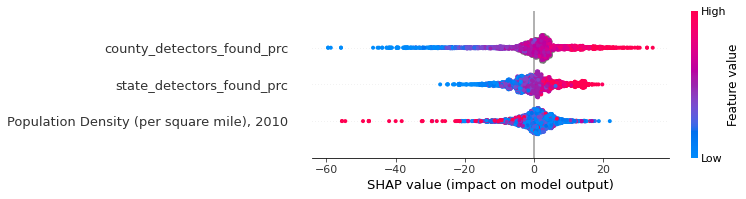

In [77]:
f, ax = plt.subplots(1, 1, figsize = (15, 10))
shap_values =shap.TreeExplainer(mdl3).shap_values(X_test)
shap.summary_plot(shap_values,X_test)
plt.show()

In [80]:
sm_all['Full_Predictions'] =  mdl.predict(rd_all.merge(ACS,how = 'left', left_index = True, right_index = True) )
sm_all['Reduced_ACS_Predictions'] =  mdl2.predict(rd_all.merge(ACS_reduced,how = 'left', left_index = True, right_index = True) )
sm_all['No_ACS_Predictions'] =  mdl3.predict(rd_all )
sm_all['Avg_Predictions']  = (sm_all['No_ACS_Predictions'] +sm_all['Reduced_ACS_Predictions']) /2 

In [81]:
sm_all.loc[:,['num_surveys','geography',
              'detectors_found_prc',
              'detectors_working_prc',
              'Full_Predictions',
              'Reduced_ACS_Predictions',
              'No_ACS_Predictions','Avg_Predictions'] ]
sm_all = sm_all.merge(rd_all['Population Density (per square mile), 2010'],how = 'left',left_index = True,right_index = True)
sm_all.index =  '#_' + sm_all.index 

In [82]:
sm_all.to_csv(path / 'Data' / 'Model Outputs' / 'SmokeAlarmPredictiveModel.csv')

In [83]:
sm_all.columns

Index(['num_surveys', 'detectors_found_total', 'detectors_found_prc',
       'detectors_found_CI', 'detectors_working_total',
       'detectors_working_prc', 'detectors_working_CI', 'geography', 'tract',
       'Full_Predictions', 'Reduced_ACS_Predictions', 'No_ACS_Predictions',
       'Avg_Predictions', 'Population Density (per square mile), 2010_x',
       'Population Density (per square mile), 2010_y'],
      dtype='object')

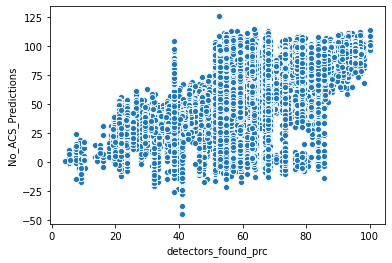

In [84]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['No_ACS_Predictions'])

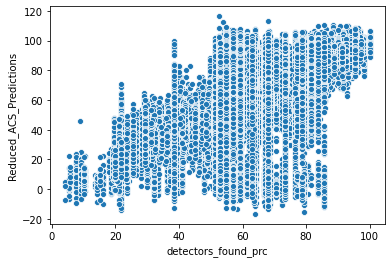

In [85]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Reduced_ACS_Predictions'])

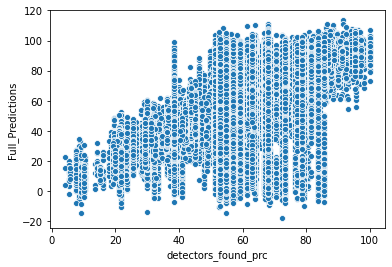

In [218]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Full_Predictions'])


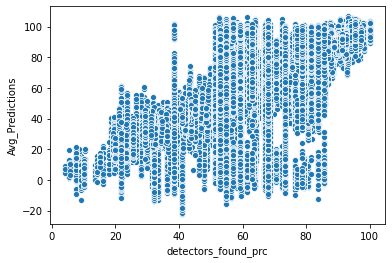

In [226]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Avg_Predictions'])


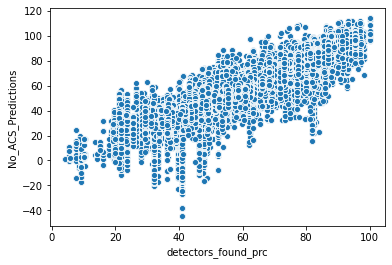

In [95]:
# plot of county predictions
sns.scatterplot(sm_all['detectors_found_prc'].where(sm_all['geography'] == 'county') ,sm_all['No_ACS_Predictions'].where(sm_all['geography'] == 'county' ) )


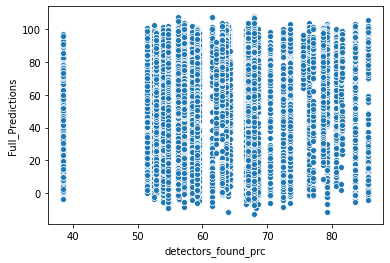

In [98]:
# plot of county predictions
sns.scatterplot(sm_all['detectors_found_prc'].where(sm_all['geography'] == 'state') ,sm_all['Avg_Predictions'].where(sm_all['geography'] == 'state' ) )